**Importing the required Libraries**

In [ ]:
pip install tensorflow

In [ ]:
pip install --upgrade tensorflow

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Cats_Dogs/Train_validation_dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Cats_Dogs/Train_validation_dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2257 files belonging to 2 classes.
Using 1806 files for training.
Found 2257 files belonging to 2 classes.
Using 451 files for validation.


**Plotting images of first training batch**

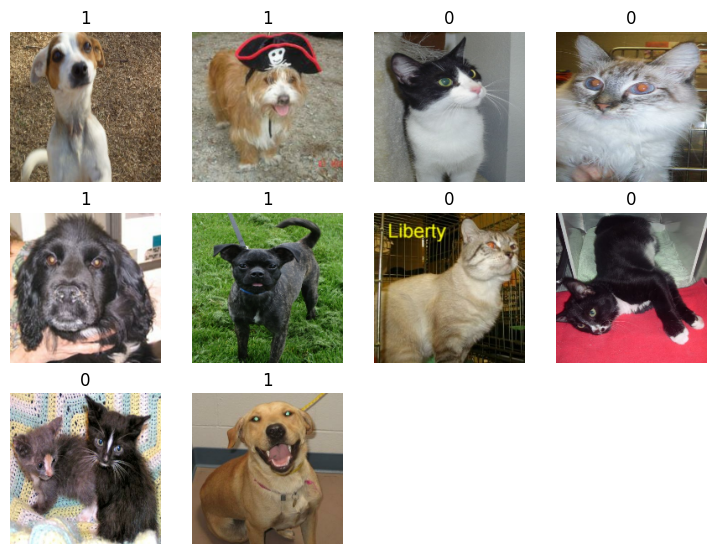

In [ ]:

plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])


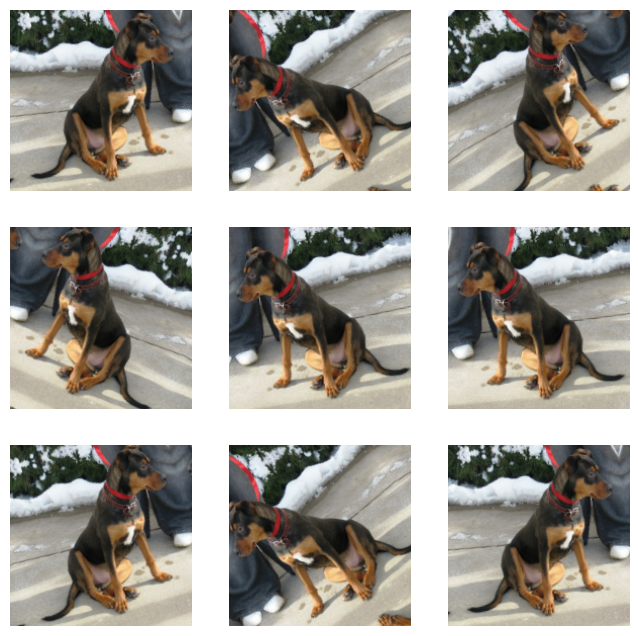

In [ ]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs =7
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/7
57/57 ━━━━━━━━━━━━━━━━━━━━ 678s 12s/step - accuracy: 0.5846 - loss: 0.7843 - val_accuracy: 0.4856 - val_loss: 0.6981
Epoch 2/7
57/57 ━━━━━━━━━━━━━━━━━━━━ 625s 11s/step - accuracy: 0.5797 - loss: 0.6956 - val_accuracy: 0.4856 - val_loss: 0.7047
Epoch 3/7
57/57 ━━━━━━━━━━━━━━━━━━━━ 625s 11s/step - accuracy: 0.6447 - loss: 0.6368 - val_accuracy: 0.4856 - val_loss: 0.7496
Epoch 4/7
57/57 ━━━━━━━━━━━━━━━━━━━━ 620s 11s/step - accuracy: 0.6867 - loss: 0.6061 - val_accuracy: 0.4856 - val_loss: 0.7375
Epoch 5/7
57/57 ━━━━━━━━━━━━━━━━━━━━ 606s 10s/step - accuracy: 0.6845 - loss: 0.5889 - val_accuracy: 0.4989 - val_loss: 0.6916
Epoch 6/7
57/57 ━━━━━━━━━━━━━━━━━━━━ 634s 11s/step - accuracy: 0.7079 - loss: 0.5652 - val_accuracy: 0.4856 - val_loss: 0.7418
Epoch 7/7
57/57 ━━━━━━━━━━━━━━━━━━━━ 602s 11s/step - accuracy: 0.7488 - loss: 0.5144 - val_accuracy: 0.5011 - val_loss: 0.7120


In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Cats_Dogs/test/cats/cat_1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
This image is 58.24 percent cat and 41.76 percent dog.


<ipython-input-21-f8afec075fd7>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "This image is %.2f percent cat and %.2f percent dog."


In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Cats_Dogs/test/dogs/dog_142.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
This image is 52.15 percent cat and 47.85 percent dog.


<ipython-input-22-39fef5461b32>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "This image is %.2f percent cat and %.2f percent dog."


In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Cats_Dogs/test/dogs/dog_173.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(score)
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[0.47854212]
This image is 52.15 percent cat and 47.85 percent dog.


<ipython-input-23-04cca2297105>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "This image is %.2f percent cat and %.2f percent dog."


In [ ]:
image_size = (180, 180)
batch_size = 32

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Cats_Dogs/test",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 140 files belonging to 2 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7140 - loss: 0.6093
Test accuracy: 0.51


In [ ]:
# Get true labels
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Get predictions
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


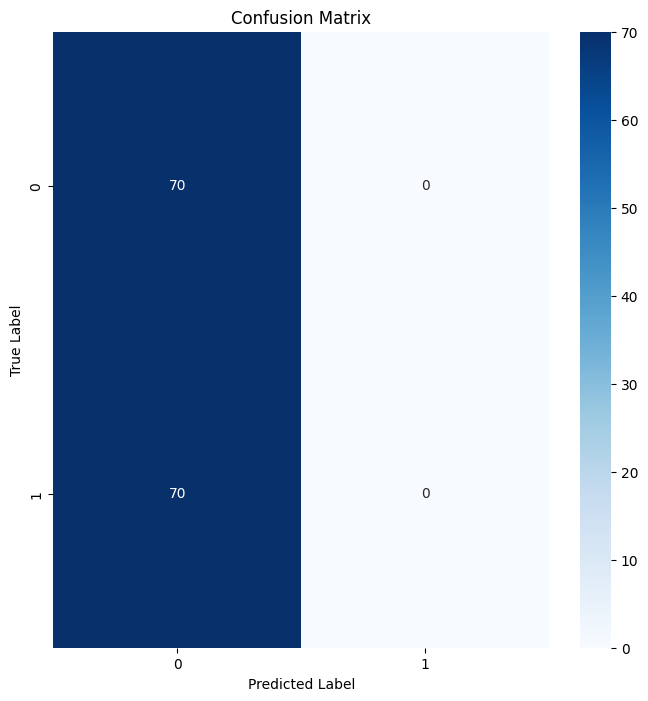

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
